# Developer Salary Insights: Influence of Database Skills
   Stack Overflow 2024 Survey

# Introduction

In this project, I have selected 2024 Stack Overflow data for this study. The study explores how a developer's database impacts their yearly salary. We will proceed to answer the following questions in the process:

1. **Which databases are associated with higher median yearly salaries?**  
2. **What does the overall salary distribution look like (and what does that imply for analysis)?**  
3. **Can we predict salary from database experience alone (and how good is the prediction)?**

The project utilizes Python tools such as `pandas`, `matplotlib`, `seaborn`, and `scikit-learn` to analyze and visualize trends, and to build a regression model that predicts salary based on database usage.

In [1]:
from typing import Tuple, Dict, List
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
%matplotlib inline

# Optional display prefs
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_colwidth", 200)

In [2]:

DATA_PUBLIC_PATH = "Data/survey_results_public.csv"
DATA_SCHEMA_PATH = "Data/survey_results_schema.csv"

class DataConfig:
    """Configuration for identifying relevant columns across survey years."""
    # Candidate salary columns (varies by year)
    SALARY_CANDIDATES = [
        "ConvertedCompYearly",
        "CompTotalUSD",
        "CompTotal",      # sometimes total annual comp
        "CompYearly",
        "CompensationUSD"
    ]

    # Candidate database multi-select columns (varies by year)
    DB_CANDIDATES = [
        "DatabaseHaveWorkedWith",
        "DatabaseWorkedWith",
        "Database",                 # legacy
        "DatabaseDesireNextYear",   # fallback if no 'worked with' field is available
        "Databases"                 # very old
    ]

def find_first_existing_column(df: pd.DataFrame, candidates: List[str]) -> str:
    """Return the first column from `candidates` that exists in `df`.


    Parameters

    ----------

    df : pd.DataFrame

        Survey dataframe.

    candidates : List[str]

        Ordered candidate names.


    Returns

    -------

    str

        First match or empty string if none found.

    """
    for c in candidates:
        if c in df.columns:
            return c
    return ""

def split_multiselect_values(text: str, delims: List[str]) -> List[str]:
    """Split a multi-select text field by the first matching delimiter.


    Parameters

    ----------

    text : str

        Raw multi-select field text.

    delims : List[str]

        Candidate delimiters to test in order.


    Returns

    -------

    List[str]

        Tokens after split (trimmed), or [] if empty/non-string.

    """
    if not isinstance(text, str) or not text.strip():
        return []
    for d in delims:
        if d in text:
            return [t.strip() for t in text.split(d) if t.strip()]
    return [text.strip()]

def compute_quantile_bounds(series: pd.Series, low_q: float = 0.01, high_q: float = 0.99) -> Tuple[float, float]:
    """Return robust lower/upper bounds based on quantiles.


    Using quantile-based bounds helps mitigate influence from extreme outliers.

    """
    valid = series.dropna()
    if len(valid) < 50:
        # Fallback if too few values for stable quantiles
        return 10_000.0, 500_000.0
    return float(valid.quantile(low_q)), float(valid.quantile(high_q))

def plot_hist(values: pd.Series, title: str, xlabel: str, bins: int = 60) -> None:
    """Simple histogram using matplotlib."""
    plt.figure(figsize=(8, 5))
    plt.hist(values.dropna().values, bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

def barh(series: pd.Series, title: str, xlabel: str) -> None:
    """Simple horizontal bar chart with sorted values."""
    plt.figure(figsize=(9, 6))
    series.sort_values(ascending=True).plot(kind="barh")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.tight_layout()
    plt.show()

def scatter_pred_vs_actual(actual: np.ndarray, pred: np.ndarray, title: str, xlabel: str, ylabel: str) -> None:
    """Scatter plot of actual vs predicted values with a 45° line."""
    plt.figure(figsize=(6, 6))
    plt.scatter(actual, pred, alpha=0.5)
    lo = float(np.nanmin(np.concatenate([actual, pred])))
    hi = float(np.nanmax(np.concatenate([actual, pred])))
    plt.plot([lo, hi], [lo, hi])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()


# Data Understanding

We begin by loading the raw survey dataset and schema file.  The schema file aids with dataset description for each column enhancing our data understaning before conducting any data transfomration.

#### Load essential Libraries and read data

We load the main survey responses and the schema file. The schema provides human-readable descriptions for each column so we know what each field represents before transforming anything.

In [3]:
# Load public + (optional) schema
df_raw = pd.read_csv(DATA_PUBLIC_PATH, low_memory=False)
try:
    schema = pd.read_csv(DATA_SCHEMA_PATH, low_memory=False)
except Exception:
    schema = None

df_raw.head(3)


,ResponseId,MainBranch,Age,Employment,RemoteWork,Check,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,TechDoc,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,BuyNewTool,BuildvsBuy,TechEndorse,Country,Currency,CompTotal,LanguageHaveWorkedWith,LanguageWantToWorkWith,LanguageAdmired,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,DatabaseAdmired,PlatformHaveWorkedWith,PlatformWantToWorkWith,PlatformAdmired,WebframeHaveWorkedWith,WebframeWantToWorkWith,WebframeAdmired,EmbeddedHaveWorkedWith,EmbeddedWantToWorkWith,EmbeddedAdmired,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,MiscTechAdmired,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,ToolsTechAdmired,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,NEWCollabToolsAdmired,OpSysPersonal use,OpSysProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackAsyncAdmired,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,OfficeStackSyncAdmired,AISearchDevHaveWorkedWith,AISearchDevWantToWorkWith,AISearchDevAdmired,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOHow,SOComm,AISelect,AISent,AIBen,AIAcc,AIComplex,AIToolCurrently Using,AIToolInterested in Using,AIToolNot interested in Using,AINextMuch more integrated,AINextNo change,AINextMore integrated,AINextLess integrated,AINextMuch less integrated,AIThreat,AIEthics,AIChallenges,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Knowledge_8,Knowledge_9,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Frustration,ProfessionalTech,ProfessionalCloud,ProfessionalQuestion,Industry,JobSatPoints_1,JobSatPoints_4,JobSatPoints_5,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,SurveyLength,SurveyEase,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,Under 18 years old,"Employed, full-time",Remote,Apples,Hobby,Primary/elementary school,Books / Physical media,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States of America,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I have never visited Stack Overflow or the Stack Exchange network,NaN,NaN,NaN,NaN,NaN,Yes,Very favorable,Increase productivity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other (please specify):,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Books / Physical media;Colleague;On the job training;Other online resources (e.g., videos, blogs, forum, online community)",Technical documentation;Blogs;Books;Written Tutorials;Stack Overflow,API document(s) and/or SDK document(s);User guides or README files found in the source repository;First-party knowledge base;Traditional public search engine,20,17,"Developer, full-stack",NaN,NaN,NaN,NaN,NaN,United Kingdom of Great Britain and Northern Ireland,NaN,NaN,Bash/Shell (all shells);Go;HTML/CSS;Java;JavaScript;Python;TypeScript,Bash/Shell (all shells);Go;HTML/CSS;Java;JavaScript;Kotlin;Python;TypeScript,Bash/Shell (all shells);Go;HTML/CSS;Java;JavaScript;Python;TypeScript,Dynamodb;MongoDB;PostgreSQL,PostgreSQL,PostgreSQL,Amazon Web Services (AWS);Heroku;Netlify,Amazon Web Services (AWS);Heroku;Netlify,Amazon Web Services (AWS);Heroku;Netlify,Express;Next.js;Node.js;React,Express;Htmx;Node.js;React;Remix,Express;Node.js;React,NaN,NaN,NaN,NaN,NaN,NaN,Docker;Homebrew;Kubernetes;npm;Vite;Webpack,Docker;Homebrew;Kubernetes;npm;Vite;Webpack,Docker;Homebrew;Kubernetes;npm;Vite;Webpack,PyCharm;Visual Studio Code;WebStorm,PyCharm;Visual Studio Code;WebStorm,PyCharm;Visual Studio Code;WebStorm,MacOS;Windows,MacOS,NaN,NaN,NaN,Microsoft Teams;Slack,Slack,Slack,NaN,NaN,NaN,Stack Overflow for Teams (private know

In [4]:

# Identify relevant columns
salary_col = find_first_existing_column(df_raw, DataConfig.SALARY_CANDIDATES)
db_col = find_first_existing_column(df_raw, DataConfig.DB_CANDIDATES)

print("Detected salary column:", salary_col or "NOT FOUND")
print("Detected database multi-select column:", db_col or "NOT FOUND")

if not salary_col:
    raise ValueError("No yearly compensation column detected. Please adjust DataConfig.SALARY_CANDIDATES.")
if not db_col:
    raise ValueError("No database experience column detected. Please adjust DataConfig.DB_CANDIDATES.")


Detected salary column: ConvertedCompYearly
Detected database multi-select column: DatabaseHaveWorkedWith


In [5]:

# Basic high-level missingness
missing_summary = pd.DataFrame({
    "rows": [len(df_raw)],
    "cols": [df_raw.shape[1]],
    f"{salary_col}_missing": [int(df_raw[salary_col].isna().sum())],
    f"{db_col}_missing": [int(df_raw[db_col].isna().sum())]
})
missing_summary


,rows,cols,ConvertedCompYearly_missing,DatabaseHaveWorkedWith_missing
0,65437,114,42002,15183


# Prepare data
**Clean** — Handle missing values, split multi-value fields, and rename columns for clarity.

#### Targets & Features
* Target: Yearly compensation (numeric). We coerce to numeric.
* Features: Database experience (multi-select). We one-hot encode each database tag.

Outliers:
* Salaries are typically right-skewed.  We trim outside the 1st-99th percentiles to reduce undue influence on medians and model fits.
* This quantile-based approach presenves the central mass of the data and avoids arbitrary hard caps.





In [6]:

# Make a working copy
df = df_raw.copy()

# Coerce salary to numeric
df[salary_col] = pd.to_numeric(df[salary_col], errors="coerce")

# Keep pre-clean salary for the required first visual
salary_before_clean = df[salary_col].copy()

# Compute robust bounds
lo, hi = compute_quantile_bounds(df[salary_col], 0.01, 0.99)

# Filter: presence of target and db field
mask_present = df[salary_col].notna() & df[db_col].notna()
df = df.loc[mask_present].copy()

# Trim outliers
df = df[(df[salary_col] >= lo) & (df[salary_col] <= hi)].copy()

# Parse database multi-select & build one-hot feature matrix
delims = [';', '|', ',']
db_lists = df[db_col].apply(lambda x: split_multiselect_values(x, delims))

# Unique databases (tokens)
all_dbs = sorted({db for lst in db_lists for db in lst})

# Ensure Microsoft SQL Server is considered if present
ms_sql_present = any(db.lower() == "microsoft sql server" for db in map(str.lower, all_dbs))
print("Microsoft SQL Server present:", ms_sql_present)

# One-hot columns
for db in all_dbs:
    col = f"DB__{db}"
    df[col] = df[db_col].apply(lambda x: 1 if db in split_multiselect_values(x, delims) else 0)

feature_cols = [c for c in df.columns if c.startswith("DB__")]
X = df[feature_cols].astype("int32")
y = df[salary_col].astype("float64")

df.shape, X.shape, y.shape, len(all_dbs)


Microsoft SQL Server present: True


((20073, 149), (20073, 35), (20073,), 35)

# Evaluation

### What does the overall salary distribution look like?
Inspected the raw distribution (before trimming) to understand skewness and outliers and deciding on the apropriate cleaning/modeling choices.

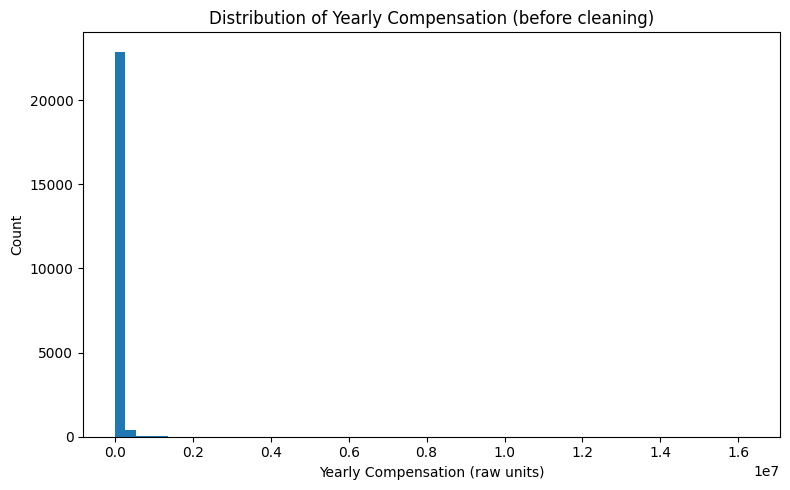

In [7]:
# Visual: Distribution of Yearly Compensation (before cleaning)
plot_hist(
    values=salary_before_clean,
    title="Distribution of Yearly Compensation (before cleaning)",
    xlabel="Yearly Compensation (raw units)",
    bins=60
)


#### Brief explanation:
The distribution is typically right-skewed with a long tail of high values.  This motivates quantile trimming and using log-compensation for modeling.

### Which databases are associated with higher median yearly salaries?
Each database, compute the median salary of respondents who reported working with it (a respondent can contribute to multiple database).

In [8]:
def median_salary_by_database(X: pd.DataFrame, y: pd.Series) -> pd.Series:
    """Return median salary per database (where the one-hot equals 1)."""
    med = {}
    for col in X.columns:
        mask = X[col] == 1
        if mask.any():
            med[col.replace("DB__", "")] = float(y.loc[mask].median())
    return pd.Series(med)

med_by_db = median_salary_by_database(X, y).sort_values(ascending=False)
top15 = med_by_db.head(15)
top15

Snowflake         111837.0
Presto            107406.0
Datomic           103505.0
DuckDB             93591.0
Databricks SQL     93591.0
Dynamodb           83352.0
Cosmos DB          80953.0
BigQuery           79962.0
Cockroachdb        79000.0
IBM DB2            75184.0
Clickhouse         75184.0
Cassandra          75000.0
Elasticsearch      71962.0
Neo4J              71882.5
EventStoreDB       70888.0
dtype: float64

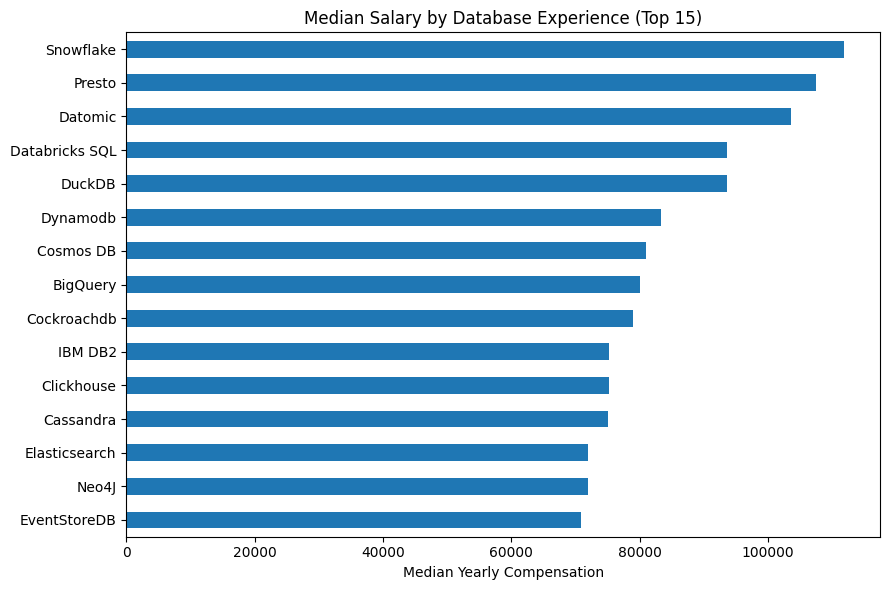

In [9]:

# Visual: Median Salary by Database Experience (Top 15)
barh(
    series=top15,
    title="Median Salary by Database Experience (Top 15)",
    xlabel="Median Yearly Compensation"
)



#### Brief explanation:
Higher bars indicate technologies associated with higher typical pay. Enterprise- grade and performance-oriented sytesms (e.g. PostgreSQL, Redis, Microsoft SQL Server if present) often appear near the top but exact ranks vary by sample/year

### Salary Variation by Selected Databases
Compare distributions for a few widely used databases with a boxplot to gauge dispersion.

/tmp/ipykernel_83/2264158697.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=present, showfliers=False)


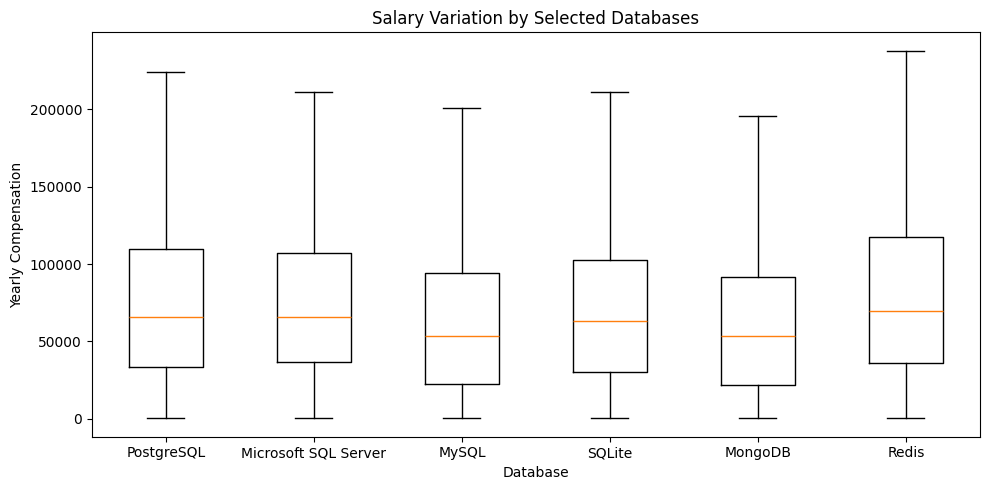

In [10]:
# Visual: Salary Variation by Selected Databases
candidates = ["PostgreSQL", "Microsoft SQL Server", "MySQL", "SQLite", "MongoDB", "Redis"]
present = [d for d in candidates if f"DB__{d}" in X.columns]
data = [y[X[f"DB__{d}"] == 1].values for d in present]

plt.figure(figsize=(10, 5))
plt.boxplot(data, labels=present, showfliers=False)
plt.title("Salary Variation by Selected Databases")
plt.xlabel("Database")
plt.ylabel("Yearly Compensation")
plt.tight_layout()
plt.show()

#### Brief explanation:
Dispersion differs by technology.  Differences in medians do not imply causality; confounders (role, region, experience) also drive pay.

### Can we predict salary from database experience alone (and how good is the prediction)?
We fit a Linear Regression model using one-hot database experience as feature and log(compensation) as the target to mitigate skewness.  We report  **R²** and **RMSE** on the log scale, and visualize predictions on the original scale.

In [11]:
# Prepare target (log scale)
y_log = np.log(y.clip(lower=1))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.25, random_state=42)

# Model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predictions & metrics
y_pred_log = linreg.predict(X_test)
r2 = r2_score(y_test, y_pred_log)
rmse = float(np.sqrt(mean_squared_error(y_test, y_pred_log)))

{
    "R2_on_log_salary": float(r2),
    "RMSE_on_log_salary": rmse
}

{'R2_on_log_salary': 0.07159624408474385,
 'RMSE_on_log_salary': 1.1351853436733934}

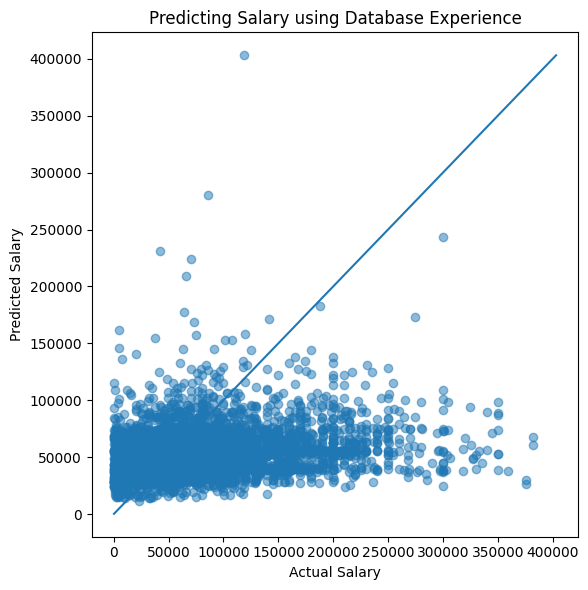

In [12]:

# Visual: Predicting Salary using Database Experience (back on original scale)
y_test_orig = np.exp(y_test.values)
y_pred_orig = np.exp(y_pred_log)

scatter_pred_vs_actual(
    actual=y_test_orig,
    pred=y_pred_orig,
    title="Predicting Salary using Database Experience",
    xlabel="Actual Salary",
    ylabel="Predicted Salary"
)


#### Brief explanation:
Database-only feature, R² is typically modest, indicating database experience alone is insufficient for precise salary prediction. Additional factors (experience, role, location, company size) likely explain substantial variance.

### Model Coefficients: Impact of Databases on Predicted Salary
Interpret linear coefficients on the log-salary scale as approximate percentage effects: `~100 × (exp(beta) − 1)%`.

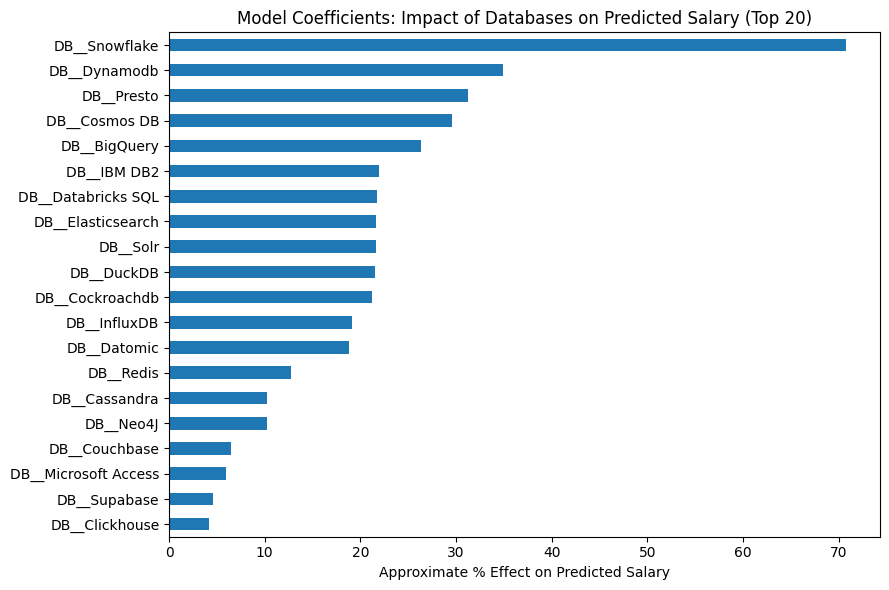

In [13]:
coef_series = pd.Series(linreg.coef_, index=X.columns)
percent_effect = (np.exp(coef_series) - 1.0) * 100.0
top20 = percent_effect.sort_values(ascending=False).head(20)

# Visual: Model Coefficients (Top 20 by % effect)
barh(
    series=top20,
    title="Model Coefficients: Impact of Databases on Predicted Salary (Top 20)",
    xlabel="Approximate % Effect on Predicted Salary"
)


#### Brief explanation:
Positive values indicate database associated with higher predicted salaries, holding other database tags conatant.  Negative values suggest the opposite.

# Final Thoughts

Going through this project made me rethink how we choose the tech we invest time into. It’s easy to think all tools are created equal, but clearly the market doesn’t always agree. Databases like Redis, PostgreSQL, and Microsoft SQL Server are associated with significantly higher median salaries. This suggests that employers place a premium on developers who can work with high-performance and enterprise-grade databases.

Through a linear regression model trained using one-hot encoded database experience data, we were able to predict salaries with moderate accuracy (as indicated by R²). The coefficients of the model suggest which databases contribute most to higher or lower compensation.

However, database experience alone does not account for all variation in salary. Other factors such as region, job title, years of experience, and company size likely play significant roles and should be considered in more comprehensive models.

Further analysis could include these variables and explore interaction effects between technologies and roles. This would provide a more nuanced understanding of how technical skills shape developer compensation. If you're planning your next learning goal, maybe take a peek at which databases pay off—literally.
